In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [5]:
import os
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms.v2 import (Compose, Resize, RandomHorizontalFlip, ToDtype, Normalize)

In [6]:
img_dir = os.path.abspath('PokemonData')
img_labels = sorted(os.listdir(img_dir))
stoi = {l: i for i, l in enumerate(img_labels)}
itos = {i: l for i, l in enumerate(img_labels)}

In [7]:
lr = .1
num_epochs = 101
device = 'cuda' if torch.cuda.is_available() else 'cpu'
momentum = .9
weight_decay = .0001
print(f'Using {device}')

Using cuda


In [8]:
class PokemonImageDataset(Dataset):

  def __init__(self, img_dir, img_labels, labels_to_idx, transform=None):
    self.img_dir = img_dir
    self.transform = transform
    self.img_labels = img_labels
    self.labels_to_idx = labels_to_idx
    self.file_list = self._build_file_list()

  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self, idx):
    img_path, label = self.file_list[idx]
    img = read_image(img_path, mode=ImageReadMode.RGB)

    if self.transform:
      img = self.transform(img)
    return img, label

  def _build_file_list(self):
    return [(os.path.join(self.img_dir, label, file), self.labels_to_idx[label])
            for label in self.img_labels
            for file in os.listdir(os.path.join(self.img_dir, label))]

In [9]:

transforms = Compose([
  Resize(size=(224, 224)),
  RandomHorizontalFlip(),
  ToDtype(dtype=torch.float32, scale=True),
  Normalize([0.6053, 0.5874, 0.5538], [0.3392, 0.3222, 0.3360])
])

dataset = PokemonImageDataset(img_dir=img_dir,
                              img_labels=img_labels,
                              labels_to_idx=stoi,
                              transform=transforms)

In [10]:
from torch.utils.data import random_split

In [11]:
generator = torch.Generator().manual_seed(42)
train, val = random_split(dataset, [.9, .1], generator=generator)

In [12]:
from torch.utils.data import DataLoader

In [13]:
# def get_mean_and_std(loader):
#   num_pixels = 0
#   mean = torch.zeros(3)
#   std = torch.zeros(3)
#   count = 0
#   for batch, _ in loader:
#     B, C, H, W = batch.shape
#     num_pixels += B * H * W
#     mean += batch.mean((0, 2, 3)) * B
#     std += batch.std((0, 2, 3)) * B
#     count += B
#   mean /= count
#   std /= count

#   return mean, std

# loader = DataLoader(dataset, batch_size=64, shuffle=True)
# mean, std = get_mean_and_std(loader)
# print('Mean', mean, 'STD', std)

In [14]:
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


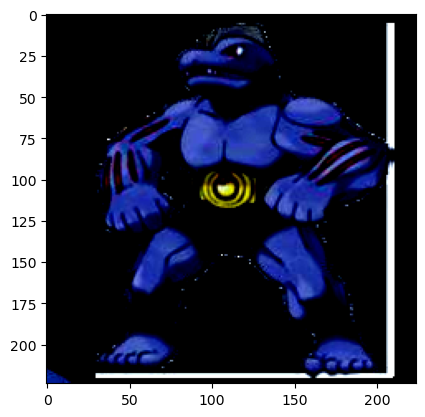

Label:  tensor(72)


In [15]:
Xtr, Ytr = next(iter(train_dataloader))
print(f'Feature batch shape: {Xtr.size()}')
print(f'Labels batch shape: {Ytr.size()}')
img = Xtr[0]
label = Ytr[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f'Label: ', label)

In [16]:
class ResidualConvolutionalNN(nn.Module):
  def __init__(self, num_labels):
    super().__init__()
    self.blocks = nn.Sequential(
      Conv1(),
      ConvN(64, 64, 3, 3, 1),
      ConvN(64, 128, 3, 4, 2),
      ConvN(128, 256, 3, 6, 2),
      ConvN(256, 512, 3, 3, 2),
    )
    self.av_l = nn.AvgPool2d(7, stride=1)
    self.fc = nn.Linear(512, num_labels)
  
  def forward(self, x, target=None):
    x = self.blocks(x)
    x = self.av_l(x)
    x = x.view(x.shape[0], -1)
    logits = self.fc(x)
    if target is None:
      loss = None
    else:
      loss = F.cross_entropy(logits, target)
    return logits, loss
  
class Conv1(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
      nn.Conv2d(3, 64, 7, stride=2, padding=3),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(3, 2, padding=1),
    )

  def forward(self, x):
    x = self.net(x)
    return x

class ConvN(nn.Module):
  def __init__(self, cin, cout, k_size, num_rc_blocks, stride):
    super().__init__()
    self.net = nn.Sequential(
      ResidConvBlock(cin, cout, k_size, stride),
      *[ResidConvBlock(cout, cout, k_size) for _ in range(num_rc_blocks - 1)]
    )
  
  def forward(self, x):
    x = self.net(x)
    return x

class ResidConvBlock(nn.Module):
  def __init__(self, cin, cout, k_size, stride=1):
    super().__init__()
    self.net = nn.Sequential(
      nn.Conv2d(cin, cout, k_size, padding=1, stride=stride),
      nn.BatchNorm2d(cout),
      nn.ReLU(),
      nn.Conv2d(cout, cout, k_size, padding=1),
    )
    self.bn = nn.BatchNorm2d(cout)
    self.relu = nn.ReLU()
    self.linear_proj = None if cin == cout else nn.Conv2d(cin, cout, 1, stride)
  
  def forward(self, x):
    if self.linear_proj is not None:
      return self.relu(self.bn(self.linear_proj(x) + self.net(x)))
    else:
      return self.relu(self.bn(x + self.net(x)))



In [17]:
model = ResidualConvolutionalNN(150)
m = model.to(device)

In [18]:
print(m)

ResidualConvolutionalNN(
  (blocks): Sequential(
    (0): Conv1(
      (net): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvN(
      (net): Sequential(
        (0): ResidConvBlock(
          (net): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU()
        )
        (1): ResidConvBlock(
          (net): Sequential(
            (0): Conv2d(64, 64

In [19]:
optimizer = torch.optim.SGD(model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

In [20]:
@torch.no_grad()
def get_val_loss(val_loader):
  losses = torch.zeros(len(val_loader))
  for i, (xb, yb) in enumerate(val_loader):
    xb = xb.to(device)
    yb = yb.to(device)
    logits, loss = m(xb, yb)
    losses[i] = loss
  
  return losses.mean()


In [56]:
for epoch in range(num_epochs):
  for xb, yb in train_dataloader:
    xb = xb.to(device)
    yb = yb.to(device)

    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    del xb, yb, logits

  val_loss = get_val_loss(val_dataloader)
  prev_lr = optimizer.param_groups[0]['lr']
  scheduler.step(val_loss)
  cur_lr = optimizer.param_groups[0]['lr']
  if epoch % 10 == 0:
    print(f'Epoch {epoch}: train loss {loss}, validation loss {val_loss}')
    print(f'Epoch {epoch} learing rate started at {prev_lr} and stepped to {cur_lr}')



Epoch 0: train loss 4.079198360443115, validation loss 4.291435718536377
Epoch 0 learing rate started at 0.1 and stepped to 0.1
Epoch 10: train loss 1.557816982269287, validation loss 2.0347933769226074
Epoch 10 learing rate started at 0.1 and stepped to 0.1
Epoch 20: train loss 0.7952536940574646, validation loss 1.4709522724151611
Epoch 20 learing rate started at 0.1 and stepped to 0.1
Epoch 30: train loss 0.021021142601966858, validation loss 1.336616039276123
Epoch 30 learing rate started at 0.010000000000000002 and stepped to 0.010000000000000002
Epoch 40: train loss 0.02778657153248787, validation loss 1.3550423383712769
Epoch 40 learing rate started at 0.0010000000000000002 and stepped to 0.0010000000000000002
Epoch 50: train loss 0.028408123180270195, validation loss 1.3178143501281738
Epoch 50 learing rate started at 0.00010000000000000003 and stepped to 0.00010000000000000003
Epoch 60: train loss 0.07293111085891724, validation loss 1.3338621854782104
Epoch 60 learing rate st

In [8]:
torch.save(model.state_dict(), os.path.join(os.path.abspath('./'), 'no_dropout_poke_classifier'))

NameError: name 'model' is not defined

In [21]:

model = ResidualConvolutionalNN(150)
model.load_state_dict(torch.load('./no_dropout_poke_classifier'))

<All keys matched successfully>

In [22]:
model.eval()

ResidualConvolutionalNN(
  (blocks): Sequential(
    (0): Conv1(
      (net): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvN(
      (net): Sequential(
        (0): ResidConvBlock(
          (net): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU()
        )
        (1): ResidConvBlock(
          (net): Sequential(
            (0): Conv2d(64, 64

In [23]:
model = model.to(device)

In [24]:
@torch.no_grad()
def get_val_loss(val_loader):
  losses = torch.zeros(len(val_loader))
  for i, (xb, yb) in enumerate(val_loader):
    xb = xb.to(device)
    yb = yb.to(device)
    logits, loss = model(xb, yb)
    losses[i] = loss
  
  return losses.mean()

In [32]:
@torch.no_grad()
def percent_correct(val_loader):
  count = 0
  total_correct = 0
  for (xb, yb) in val_loader:
    xb = xb.to(device)
    yb = yb.to(device)
    for pic, label in zip(xb, yb):
      logits, loss = model(torch.unsqueeze(pic, 0))
      soft = F.softmax(logits, 1)
      pred = torch.multinomial(soft, 1)
      count += 1
      print(label, itos[int(pred[0])])
      if label == pred[0]:
        total_correct += 1
  
  return total_correct / count

In [33]:
percent_correct(val_dataloader)

tensor(70, device='cuda:0') Charmander
tensor(45, device='cuda:0') Goldeen
tensor(65, device='cuda:0') Raticate
tensor(56, device='cuda:0') Jolteon
tensor(127, device='cuda:0') Spearow
tensor(137, device='cuda:0') Haunter
tensor(77, device='cuda:0') Magneton
tensor(28, device='cuda:0') Omanyte
tensor(93, device='cuda:0') Omanyte
tensor(106, device='cuda:0') Poliwrath
tensor(0, device='cuda:0') Abra
tensor(128, device='cuda:0') Squirtle
tensor(43, device='cuda:0') Vileplume
tensor(134, device='cuda:0') Tentacruel
tensor(69, device='cuda:0') Lapras
tensor(117, device='cuda:0') Sandshrew
tensor(44, device='cuda:0') Golbat
tensor(8, device='cuda:0') Jolteon
tensor(71, device='cuda:0') Machamp
tensor(45, device='cuda:0') Goldeen
tensor(144, device='cuda:0') Weedle
tensor(135, device='cuda:0') Vaporeon
tensor(27, device='cuda:0') Dragonite
tensor(11, device='cuda:0') Butterfree
tensor(8, device='cuda:0') Bellsprout
tensor(40, device='cuda:0') Gastly
tensor(16, device='cuda:0') Charmeleon
ten

0.7023460410557185

In [27]:
get_val_loss(val_dataloader)

tensor(1.2549)

In [33]:
preprocess = Compose([
  Resize(size=(224, 224)),
  ToDtype(dtype=torch.float32, scale=True),
  Normalize([0.6053, 0.5874, 0.5538], [0.3392, 0.3222, 0.3360])
])

In [27]:
def process_image(image):
  image_tensor = preprocess(read_image(image, mode=ImageReadMode.RGB))
  image_tensor = image_tensor.to(device)
  image_tensor = torch.unsqueeze(image_tensor, 0)
  return image_tensor


In [53]:
def predict_pokepic(processed_image):
  with torch.no_grad():
    logits, loss = model(processed_image)
    soft = torch.softmax(logits, 1)
    pred = torch.multinomial(soft, 1)
  return pred

In [62]:
pokepic = './PokeTestData/51VLw2O+odL._AC_UF894,1000_QL80_.jpg'
pokepic_processed = process_image(pokepic)
pred = predict_pokepic(pokepic_processed)

print(itos[int(pred[0])])

Charmander


In [94]:
test_pics_dir = './PokeTestData'
poke_test_pics = os.listdir(test_pics_dir)

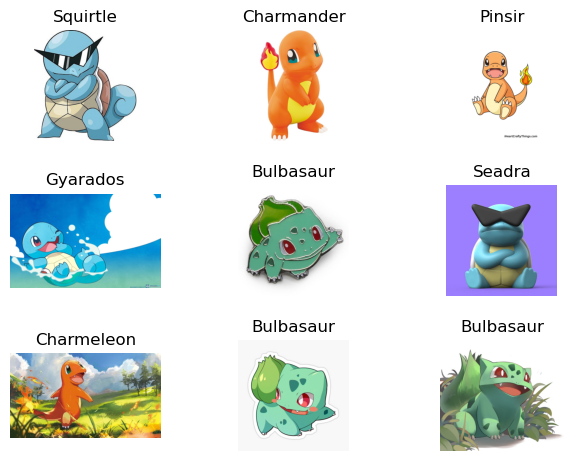

In [98]:
fig, axs = plt.subplots(3, 3)
fig.tight_layout()
for i in range(3):
  for j in range(3):
    image_path = os.path.join(test_pics_dir, poke_test_pics[3 * i + j])
    image = read_image(image_path)
    image = image.permute((1, 2, 0))
    pred = predict_pokepic(process_image(image_path))
    axs[i, j].imshow(image)
    axs[i, j].set_title(itos[int(pred[0])])
    axs[i, j].set_axis_off()